In [15]:
## Imports
import numpy as np
import torch
from PIL import Image
import os.path
import argparse
from pathlib import Path
import cv2
import heapq
from torch.nn import functional as F
from torch.utils.data import DataLoader
import tqdm
import einops
from torchvision.datasets import ImageNet
from torch.utils.data import DataLoader
from utils.factory import create_model_and_transforms, get_tokenizer
from utils.visualization import image_grid, visualization_preprocess
from prs_hook import hook_prs_logger
from matplotlib import pyplot as plt
import mediapy


In [16]:
## Hyperparameters

device = 'cuda:1'
pretrained = 'laion2b_s32b_b82k' # 'laion2b_s32b_b79k'
model_name = 'ViT-L-14' # 'ViT-H-14'
batch_size = 2 # only needed for the nn search
imagenet_path = '/datasets/ilsvrc_2024-01-04_1601/' # only needed for the nn search

In [17]:
## Loading Model

model, _, preprocess = create_model_and_transforms(model_name, pretrained=pretrained)
model.to(device)
model.eval()
context_length = model.context_length
vocab_size = model.vocab_size
tokenizer = get_tokenizer(model_name)

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)
print("Len of res:", len(model.visual.transformer.resblocks))

prs = hook_prs_logger(model, device)

Model parameters: 427,616,513
Context length: 77
Vocab size: 49408
Len of res: 24


In [25]:
def get_attention_map(file_name, text1, text2): 
    image_pil = Image.open('/home/riadoshi/clip_text_span/images/' + file_name)
    image = preprocess(image_pil)[np.newaxis, :, :, :]
    _ = plt.imshow(image_pil)

    ## Run the image:
    prs.reinit()
    with torch.no_grad():
        representation = model.encode_image(image.to(device), 
                                            attn_method='head', 
                                            normalize=False)
        attentions, mlps = prs.finalize(representation)  # attentions: [1, 32, 257, 16, 1024], mlps: [1, 33, 1024]

    ## Get the texts
    lines = [text1, text2]
    texts = tokenizer(lines).to(device)  # tokenize
    class_embeddings = model.encode_text(texts)
    class_embedding = F.normalize(class_embeddings, dim=-1)
        
    attention_map = attentions[0, :, 1:, :].sum(axis=(0,2)) @ class_embedding.T

    attention_map = F.interpolate(einops.rearrange(attention_map, '(B N M) C -> B C N M', N=16, M=16, B=1), 
                                    scale_factor=model.visual.patch_size[0],
                                    mode='bilinear').to(device)
    attention_map = attention_map[0].detach().cpu().numpy()
    print(lines[0])
    plt.imshow(attention_map[0] - np.mean(attention_map,axis=0))

    v = attention_map[0] - attention_map[1] # np.mean(attention_map,axis=0)
    min_ = min((attention_map[0] - attention_map[1]).min(), (attention_map[1] - attention_map[0]).min())
    max_ = max((attention_map[0] - attention_map[1]).max(), (attention_map[1] - attention_map[1]).max())
    v = v - min_
    v = np.uint8((v / (max_-min_))*255)
    high = cv2.cvtColor(cv2.applyColorMap(v, cv2.COLORMAP_JET), cv2.COLOR_BGR2RGB)
    plt.colorbar()
    plt.axis('off')
    plt.show()
    print(lines[1])
    plt.imshow(attention_map[1] - np.mean(attention_map,axis=0),)

    v = attention_map[1] - attention_map[0]
    v = v - min_
    v = np.uint8((v / (max_-min_))*255)
    high = cv2.cvtColor(cv2.applyColorMap(v, cv2.COLORMAP_JET), cv2.COLOR_BGR2RGB)
    plt.colorbar()
    plt.axis('off')
    plt.show()
    return plt



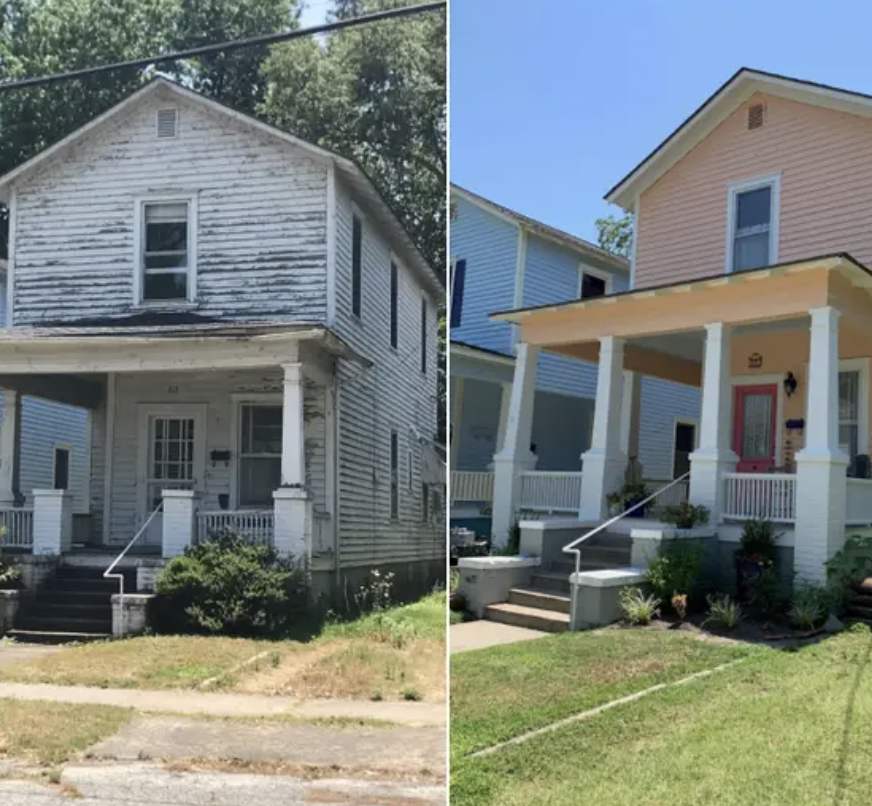

before


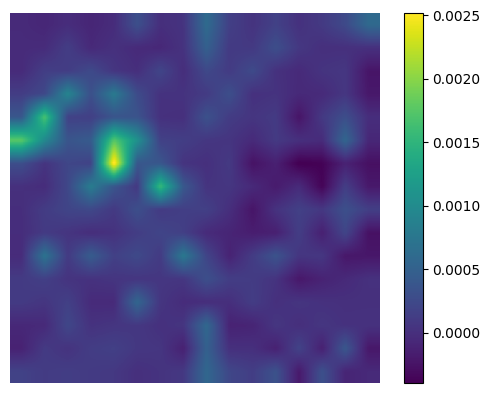

after


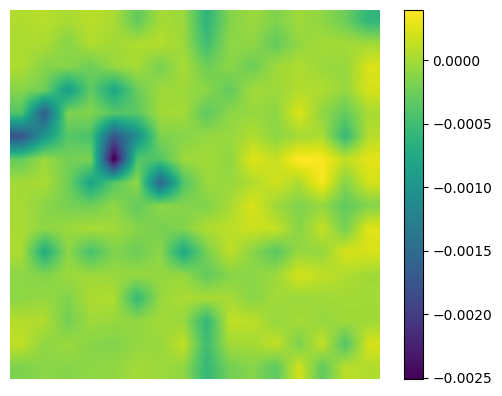

<module 'matplotlib.pyplot' from '/home/riadoshi/miniconda3/envs/prsclip/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [22]:
filename = 'before_after.png'
image_pil =Image.open('/home/riadoshi/clip_text_span/images/' + filename)
mediapy.show_image(np.array(image_pil))
get_attention_map(filename, 'before', 'after')


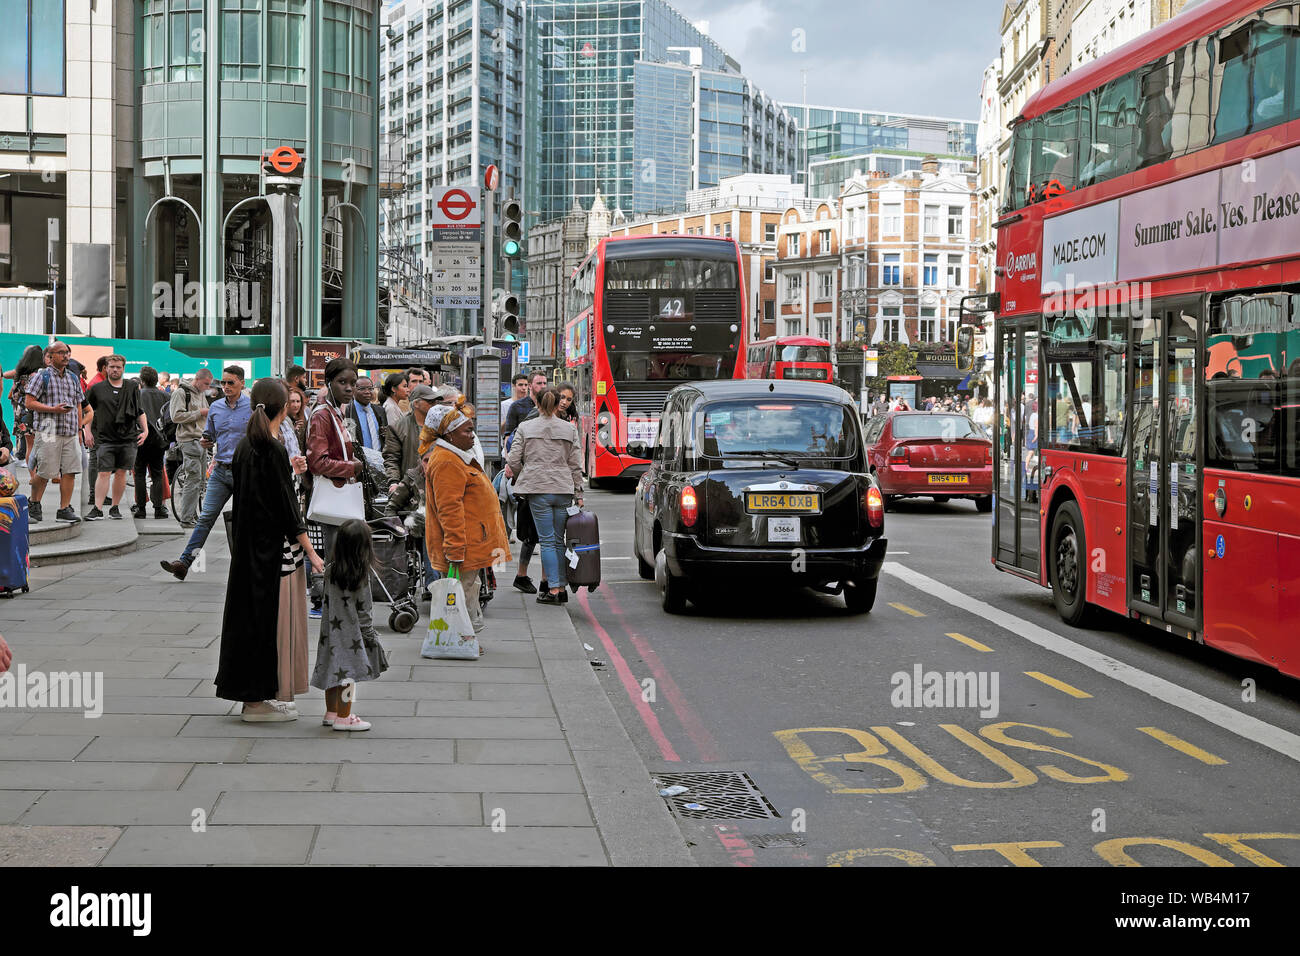

image of people


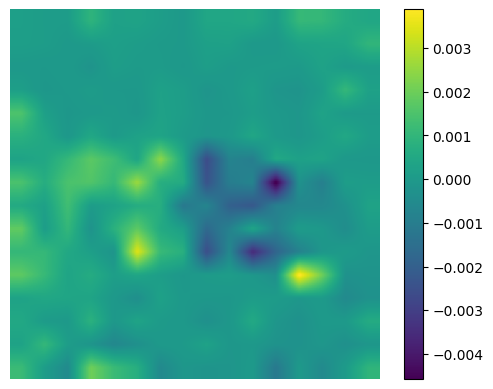

image of car


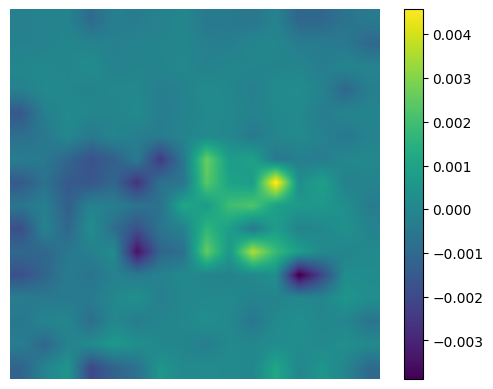

<module 'matplotlib.pyplot' from '/home/riadoshi/miniconda3/envs/prsclip/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [27]:
filename = 'people-standing-at-a-bus-stop-outside-liverpool-street-station-in-london-england-uk-kathy-dewitt-WB4M17.jpg'
image_pil =Image.open('/home/riadoshi/clip_text_span/images/' + filename)
mediapy.show_image(np.array(image_pil))
get_attention_map(filename, 'image of people', 'image of car')


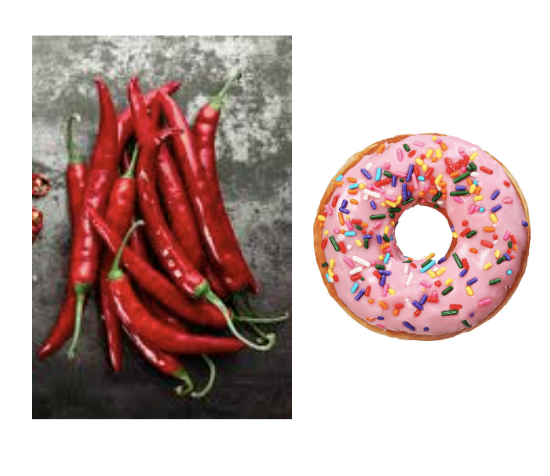

spicy food


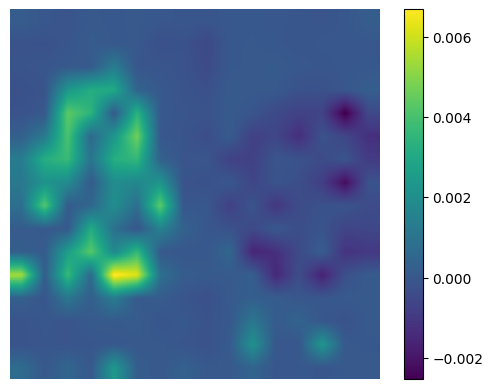

sweet food


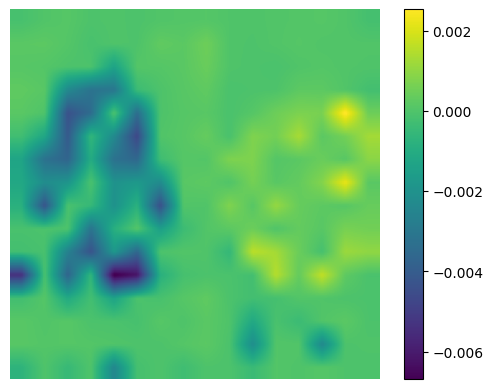

<module 'matplotlib.pyplot' from '/home/riadoshi/miniconda3/envs/prsclip/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [29]:
filename = 'sweetspicy.png'
image_pil =Image.open('/home/riadoshi/clip_text_span/images/' + filename)
mediapy.show_image(np.array(image_pil))
get_attention_map(filename, 'spicy food', 'sweet food')